In [1]:
# Import basic packages
import os
import shutil

# Import packages for working with RGB images
import numpy as np
import cv2

# Import packages for data visualization
import matplotlib.pyplot as plt

# Import base package for working with deep learning models
import torch
import torch.nn.functional as F

# Import packages to handle loading data for training a deep learning model
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

# Import packages for data augmentations
import albumentations as albu
from torchvision import transforms as T

# Import packages containing a pre-trained segmentation models, so we don't have to create structure from scratch 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

# Import packages for model evaluation
from sklearn.metrics import confusion_matrix  

# Supress Warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Setting up data to train the U-Net segmentataion model
# Check if the required training, validation and testing folders exists, if not then create it

DATA_DIR = './data/'
WSIPatches_Loc = "./patches/"
MaskPatches_Loc = "./masks/"

if os.path.isdir(DATA_DIR) == False:
    os.makedirs(DATA_DIR)
    os.makedirs(DATA_DIR+'train/')
    os.makedirs(DATA_DIR+'trainannot/')

    os.makedirs(DATA_DIR+'val/')
    os.makedirs(DATA_DIR+'valannot/')

    os.makedirs(DATA_DIR+ 'test/')
    os.makedirs(DATA_DIR+ 'testannot/')
    


In [3]:
# Split patches into training/validation and test in the following ratio - 60:20:20

allFileNames = os.listdir(WSIPatches_Loc)

np.random.shuffle(allFileNames)

training = allFileNames[:int(len(allFileNames)*0.6)]
validation = allFileNames[int(len(allFileNames)*0.6):int(len(allFileNames)*0.8)]
testing = allFileNames[int(len(allFileNames)*0.8):]

for name in training:
    shutil.copy(WSIPatches_Loc+name, DATA_DIR+'train/')
    shutil.copy(MaskPatches_Loc+name, DATA_DIR+'trainannot/')

for name in validation:
    shutil.copy(WSIPatches_Loc+name, DATA_DIR+'val/')
    shutil.copy(MaskPatches_Loc+name, DATA_DIR+'valannot/')
    
for name in testing:
    shutil.copy(WSIPatches_Loc+name, DATA_DIR+'test/')
    shutil.copy(MaskPatches_Loc+name, DATA_DIR+'testannot/')


In [4]:
# Training U-NET segmentation model
# Initializing U-Net Variables

x_train_dir = os.path.join(DATA_DIR, 'train/')
y_train_dir = os.path.join(DATA_DIR, 'trainannot/')

x_valid_dir = os.path.join(DATA_DIR, 'val/')
y_valid_dir = os.path.join(DATA_DIR, 'valannot/')

x_test_dir = os.path.join(DATA_DIR, 'test/')
y_test_dir = os.path.join(DATA_DIR, 'testannot/')


In [5]:
# Helper Functions

# This function plots either a single or multiple images in the notebook output cell
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

    
# This function generates the evaluation metrics (Intersection over Union, iou) for the segmentation model
def compute_iou(y_pred, y_true):
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = current[1,1]
    ground_truth_set = current[1,:].sum()
    predicted_set = current[:,1].sum()
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [6]:
# This class arranges wsi patches and mask patches as a single unit and also performs augmentataion steps.

class Dataset(BaseDataset):
    
    CLASSES = ['tumor']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(np.invert(masks), axis=-1).astype('float')
        
        
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

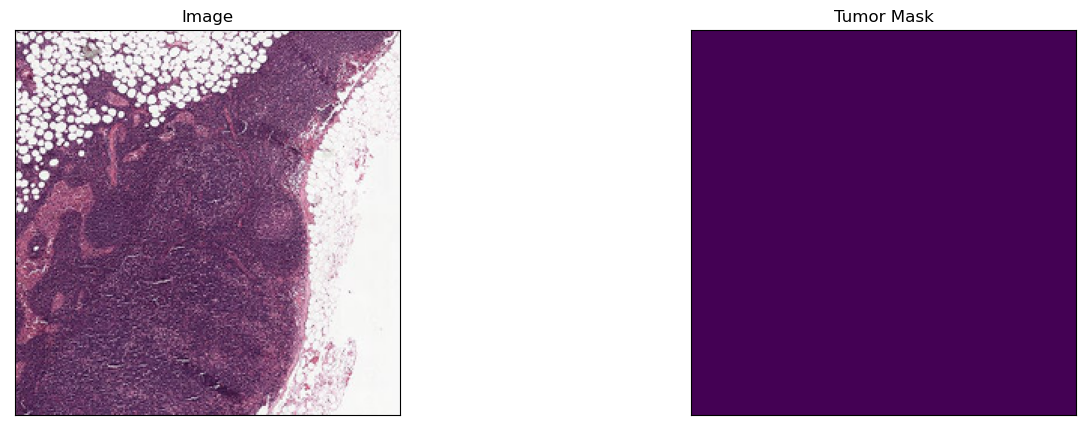

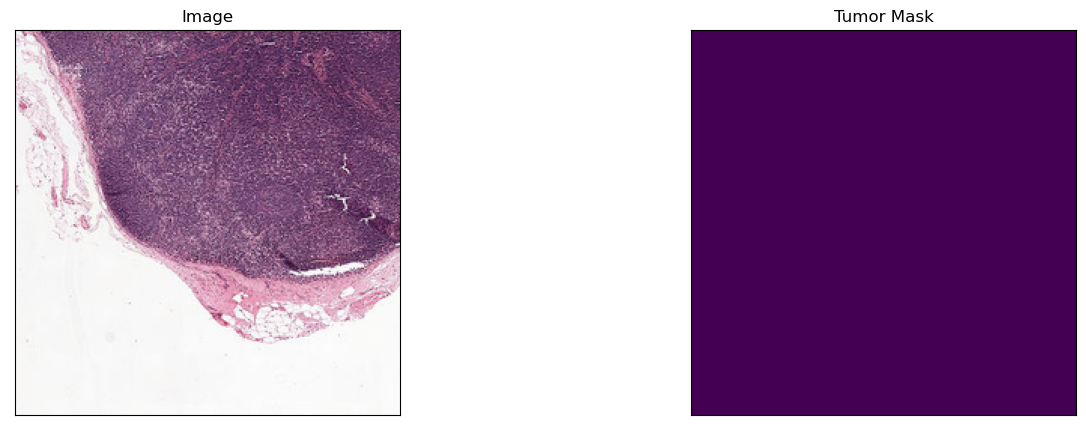

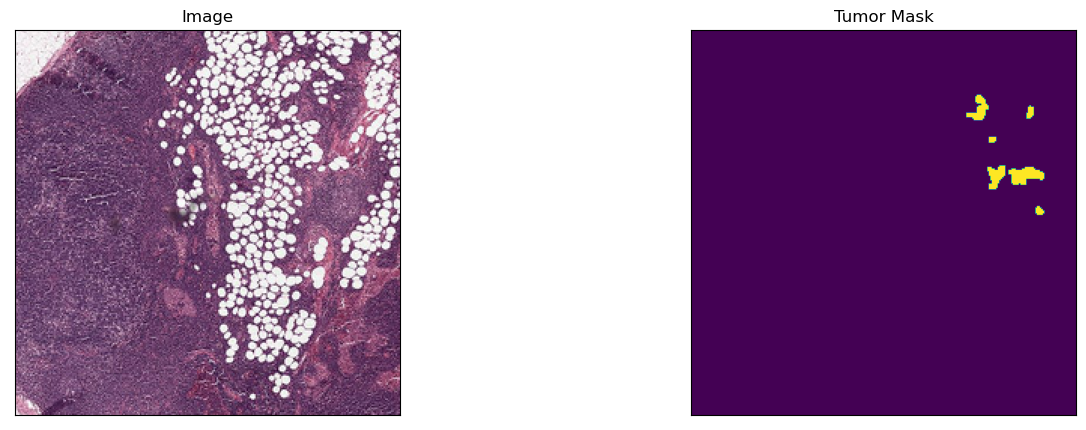

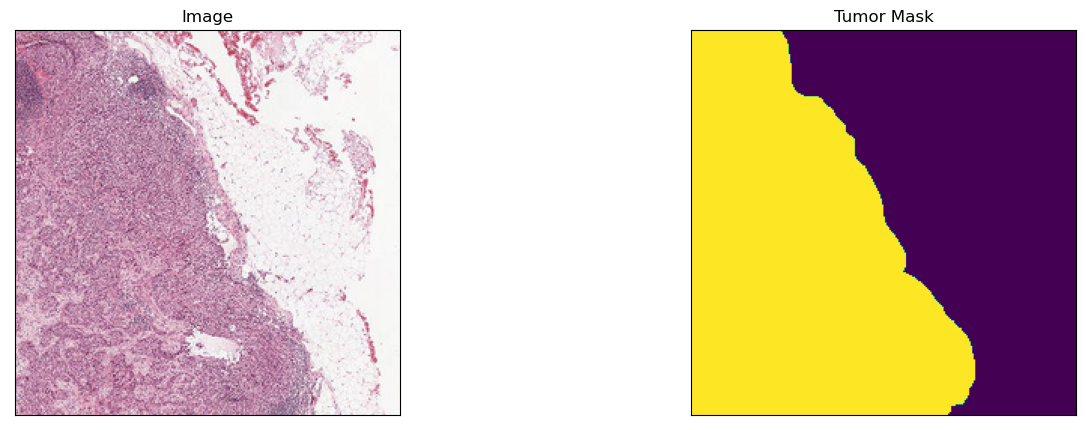

In [7]:
# Take a look at a single patch and its corresponding mask

dataset = Dataset(x_train_dir, y_train_dir, classes=['tumor'])


for i in range(4):
    image, mask = dataset[i] # get some sample
    visualize(image=image,tumor_mask=mask)

# All these batches are not augmented. This step is just a visualization check to ensure that your masks are in line with your pathes

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [9]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation(): #The ttaining set will be augmented, but to make the validation set to be as realistic as possible, we don't augment the validation set, so the model will still perform well on future images unseen before
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

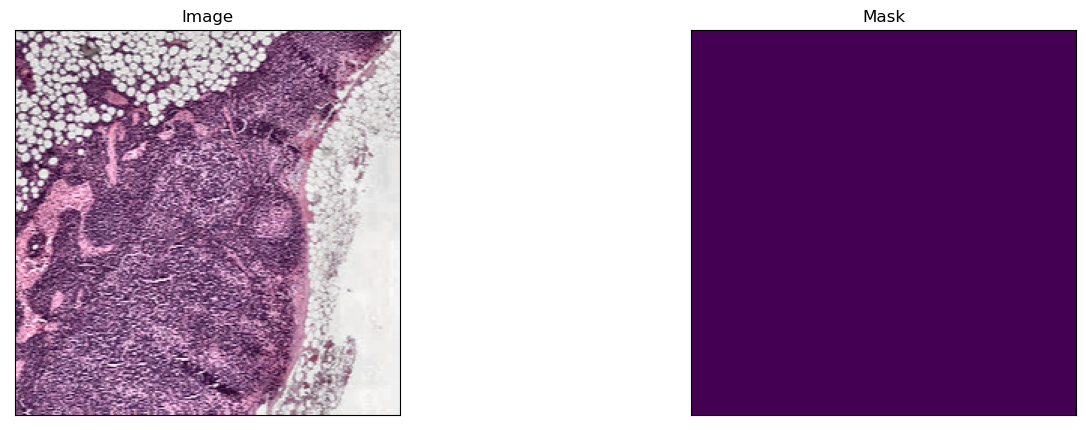

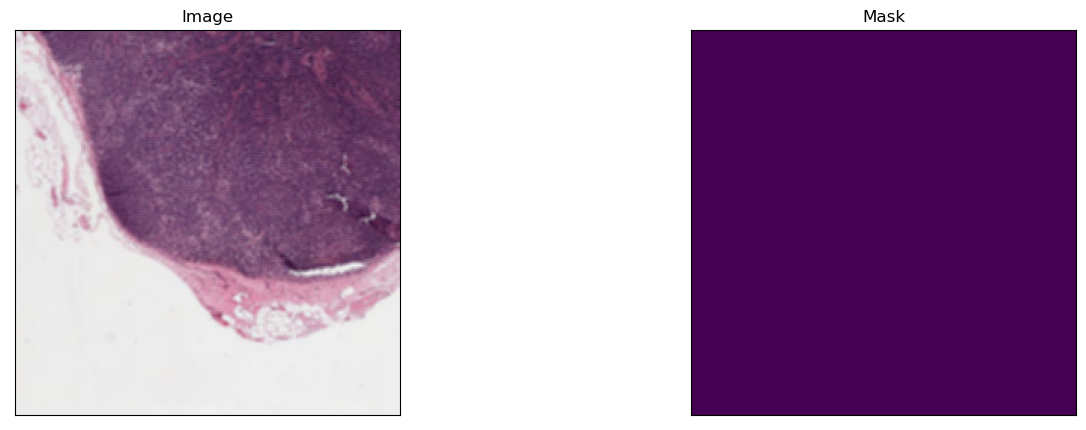

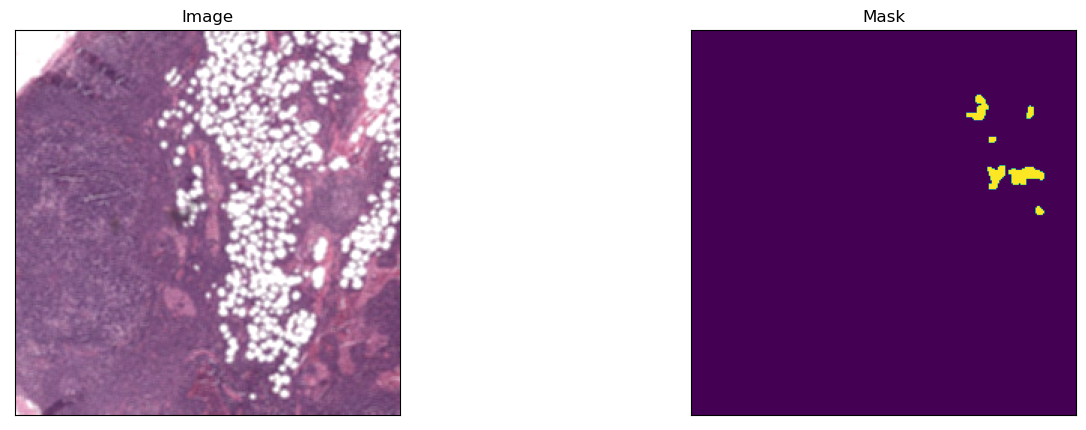

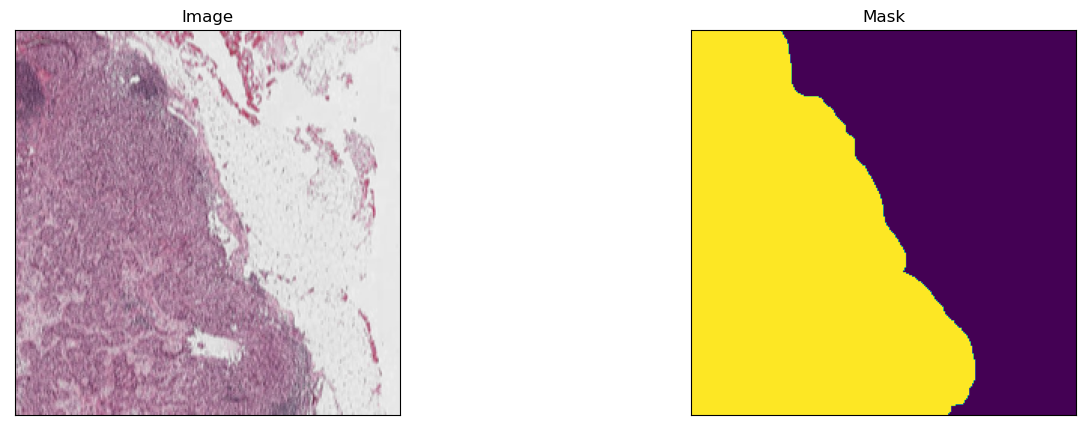

In [14]:
# Visualize resulted augmented pacthes and its corresponding masks
# Augmentation is a way to get more data--it might tilt or flipp or blur your original image a bit etc. This step also creates more robust model 
# The prof mentioned that they actually test the same slides scanned by a scanner and a cell phone mounted on a microscope and porved that a cell phone can work as well as a scanner (if you're poor)

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['tumor'],
)

# same image with different random transforms
for i in range(4):
    image, mask = augmented_dataset[i]
    visualize(image=image, mask=mask)

## Create model and train

In [15]:
# Initialize parameters for the segmentation model
# RESOURCE: https://github.com/qubvel/segmentation_models.pytorch#architectures
ENCODER = 'timm-mobilenetv3_small_100'
ENCODER_WEIGHTS = 'imagenet' #You can train the model from scratch or just use pre-exisitng weights come with the pre-trained model 
CLASSES = ['tumor']
ACTIVATION = 'sigmoid' #The model will generate a numerical value and the sigmoid function will make that numerical value into either 0 or 1 for the classfiication purpose
DEVICE = 'cpu' #Use "cuda" if you want to use GPU, which is faster than CPU

model = smp.Unet(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_mobilenetv3_small_100-37f49e2b.pth" to /home/jovyan/.cache/torch/hub/checkpoints/tf_mobilenetv3_small_100-37f49e2b.pth


  0%|          | 0.00/9.78M [00:00<?, ?B/s]

In [16]:
# Iterate through the training and validation datasets and perform augmentations

train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

# Load the augmented data in batches using DataLoader because sometimes your computer's memory isn't large enough to load all the data at once 

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0) #Shuffle will remove the sequence order and mix up the order of how the training set is loaded
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=0)

In [17]:
# Initialize loss function to quantify how off your model's prediction is from the ground truth 
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = utils.losses.DiceLoss()

metrics = [
    utils.metrics.IoU(threshold=0.5),
]

# Initialize optimizers

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [18]:
# create epoch runners - it is a simple loop of iterating over dataloader`s samples
# 1 epoch is going through all the batches you have 
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [19]:
# train model for n epochs
# This cell will take some time to run 
max_score = 0

total_epochs  = 2

modelLoc = "./saved_model/" 

for i in range(0, total_epochs):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # Save the model when loss value improves
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        if os.path.isdir(modelLoc) == False:
            os.makedirs(modelLoc)
            torch.save(model, modelLoc+'best_model.pth')
        else:
            torch.save(model, modelLoc+'best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train: 100% 2/2 [10:03<00:00, 301.95s/it, dice_loss - 0.7981, iou_score - 0.1012]
valid: 100% 1/1 [01:25<00:00, 85.70s/it, dice_loss - 0.552, iou_score - 0.2809]
Model saved!

Epoch: 1
train: 100% 2/2 [07:50<00:00, 235.24s/it, dice_loss - 0.7516, iou_score - 0.1692]
valid: 100% 1/1 [00:39<00:00, 39.10s/it, dice_loss - 0.4997, iou_score - 0.3488]
Model saved!


## Test best saved model

In [20]:
# load best saved checkpoint
best_model = torch.load(modelLoc+'best_model.pth')

In [21]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir,  
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [22]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100% 3/3 [00:40<00:00, 13.35s/it, dice_loss - 0.6475, iou_score - 0.2561]


## Visualize predictions using  Intersection Over Union (IoU)

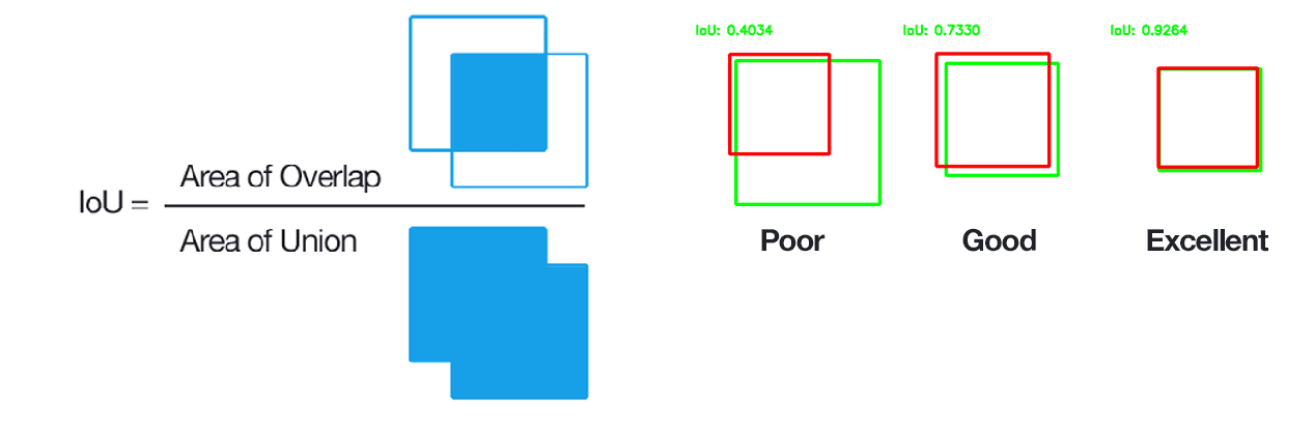

In [23]:
# Test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

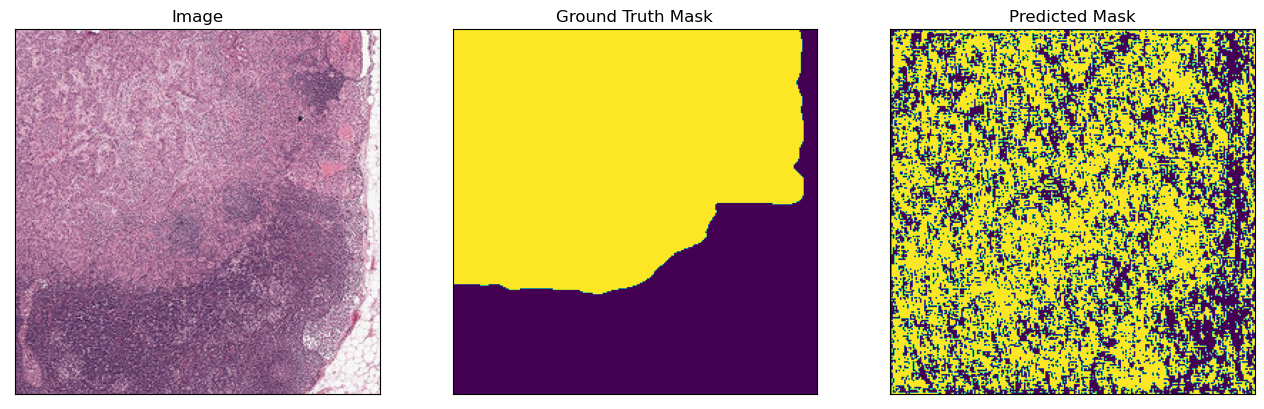

-----------------------------
IoU: 0.4658661531754105
-----------------------------


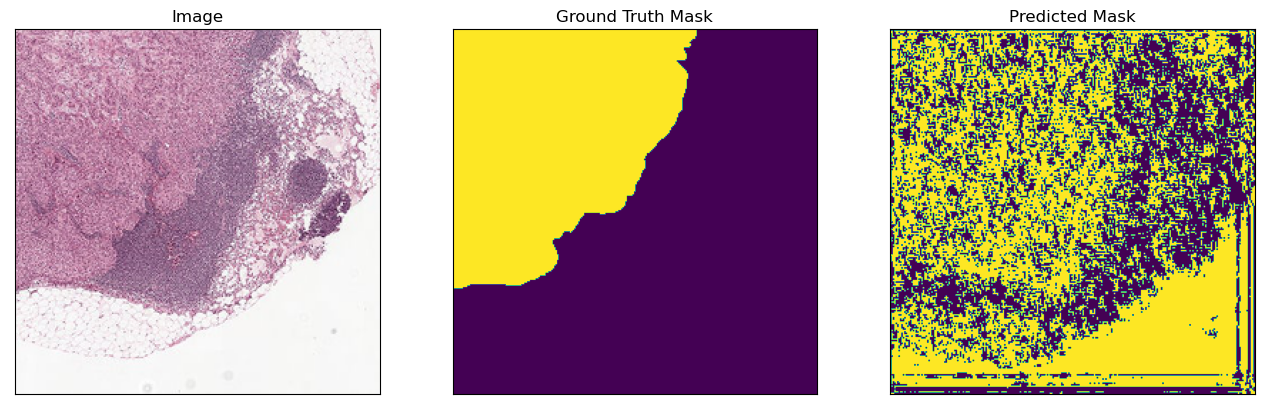

-----------------------------
IoU: 0.30242274101444405
-----------------------------


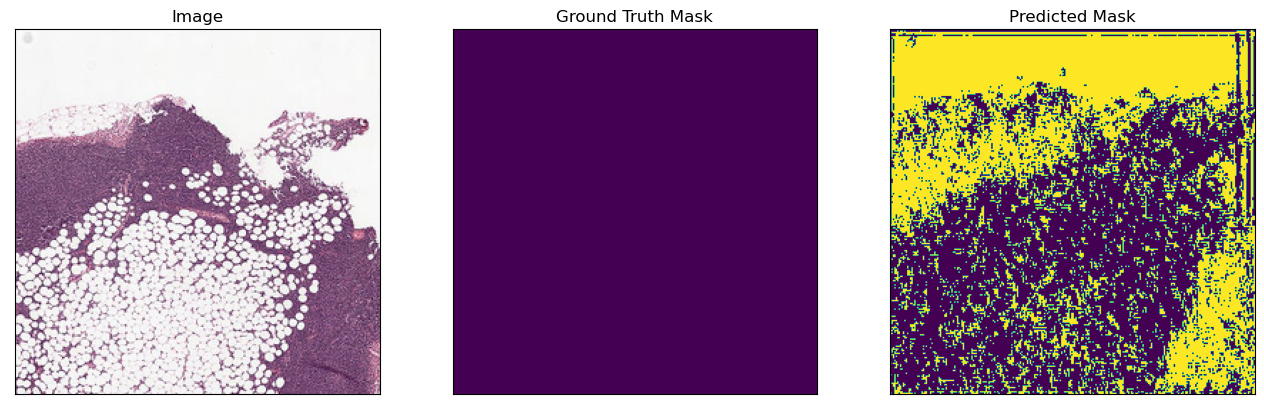

-----------------------------
IoU: 0.0
-----------------------------


In [24]:
# Visualize predictions on images from the test dataset

for i in range(3):
    
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    
    score = compute_iou(pr_mask, gt_mask)
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )
    
    print("-----------------------------")
    print("IoU: "+str(score))
    print("-----------------------------")
    
# If your ground truth mask is totally 0, then you can get IoU as 0 

In [ ]:
#--------------------------------------------End of Coding Session 2-----------------------------------------------------------#